In [1]:
import ee

ee.Authenticate()
ee.Initialize()
print("Authenticated and initialized successfully!")


Successfully saved authorization token.
Authenticated and initialized successfully!


In [2]:
import json

In [5]:
with open("E:\EK_Intern\CropMonitoring\\api\cfg\json\dakya.json") as f:
    dakya = json.load(f)

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\Dat\AppData\Local\Temp\ipykernel_13280\1544807805.py:1: SyntaxWarning: invalid escape sequence '\E'
  with open("E:\EK_Intern\CropMonitoring\\api\cfg\json\dakya.json") as f:


In [6]:
geometry = ee.Geometry(dakya)

In [19]:
START_DATE = '2020-01-01'
END_DATE = '2020-02-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [20]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [21]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [22]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [23]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(geometry, START_DATE, END_DATE)

In [24]:
# Load a Sentinel-2 L2A image collection for the area defined by the bounding box
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
                        .filterBounds(geometry)\
                        .filterDate('2020-01-01', '2020-03-01')\
                 
                        
# Get the number of images in the collection
image_count = sentinel2_collection.size().getInfo()
print(f"Number of images in the collection: {image_count}")

# Convert the image collection to a list for iteration
image_list = sentinel2_collection.toList(image_count)

Number of images in the collection: 24


In [25]:
import requests
import os
from tqdm import tqdm

for i in tqdm(range(image_count), desc="Downloading Image"):
    # Select the i-th image from the list
    image = ee.Image(image_list.get(i)).clip(geometry)

    # Request a download URL for the image (RGB + NIR bands)
    download_url = image.select(['B4', 'B3', 'B2', 'B8']).getDownloadURL({
        'scale': 10,  # Resolution in meters
        'region': geometry,  # Region as GeoJSON
        'format': 'GeoTIFF'
    })

    # Download the image from the URL
    response = requests.get(download_url)

    folder = 'E:\EK_Intern\CropMonitoring\\api\\assests'
    
    if not os.path.exists(f'{folder}\\tests_img'):
        os.makedirs(f'{folder}\\tests_img')
        
    image_filename = f"{folder}\\tests_img\\sentinel2_image_{i+1}.tif"
    
    with open(image_filename, 'wb') as f:
        f.write(response.content)
    
    #print(f"Image {i+1} saved locally as {image_filename}")

<>:19: SyntaxWarning: invalid escape sequence '\E'
<>:19: SyntaxWarning: invalid escape sequence '\E'
C:\Users\Dat\AppData\Local\Temp\ipykernel_13280\1571650808.py:19: SyntaxWarning: invalid escape sequence '\E'
  folder = 'E:\EK_Intern\CropMonitoring\\api\\assests'

Image 1 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_1.tif


Image 2 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_2.tif


Image 3 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_3.tif


Image 4 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_4.tif


Image 5 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_5.tif


Image 6 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_6.tif


Image 7 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_7.tif


Image 8 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_8.tif


Image 9 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_9.tif


Image 10 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_10.tif


Image 11 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_11.tif


Image 12 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_12.tif


Image 13 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_13.tif


Image 14 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_14.tif


Image 15 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_15.tif


Image 16 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_16.tif


Image 17 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_17.tif


Image 18 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_18.tif


Image 19 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_19.tif


Image 20 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_20.tif


Image 21 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_21.tif


Image 22 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_22.tif


Image 23 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_23.tif


Image 24 saved locally as E:\EK_Intern\CropMonitoring\api\assests\tests_img\sentinel2_image_24.tif


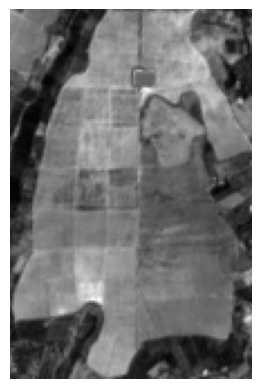

In [2]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file with rasterio
with rasterio.open(r'E:/EK_Intern/CropMonitoring/api/assests/tests_img/sentinel2_image_10.tif') as src:
    # Read the first band (assuming a multi-band image, you can choose which bands to read)
    band1 = src.read(1)

# Display the first band
plt.imshow(band1, cmap='gray')  # Use cmap='gray' for grayscale display
plt.axis('off')
plt.show()

